# 1.3 – Computation on NumPy Arrays: Universal Functions

Up until now, we have been discussing some of the basic nuts and bolts of NumPy; in todays lecture, we will dive into the reasons that NumPy is so important in the Python data science world.
Namely, it provides an easy and flexible interface to optimized computation with arrays of data.

Computation on NumPy arrays can be very fast, or it can be very slow.
The key to making it fast is to use *vectorized* operations, generally implemented through NumPy's *universal functions* (ufuncs).
This section motivates the need for NumPy's ufuncs, which can be used to make repeated calculations on array elements much more efficient.
It then introduces many of the most common and useful arithmetic ufuncs available in the NumPy package.

## The Slowness of Loops

Python's default implementation (known as CPython) does some operations very slowly.
This is in part due to the dynamic, interpreted nature of the language: the fact that types are flexible, so that sequences of operations cannot be compiled down to efficient machine code as in languages like C and Fortran.
Recently there have been various attempts to address this weakness: well-known examples are the [PyPy](http://pypy.org/) project, a just-in-time compiled implementation of Python; the [Cython](http://cython.org) project, which converts Python code to compilable C code; and the [Numba](http://numba.pydata.org/) project, which converts snippets of Python code to fast LLVM bytecode.
Each of these has its strengths and weaknesses, but it is safe to say that none of the three approaches has yet surpassed the reach and popularity of the standard CPython engine.

The relative sluggishness of Python generally manifests itself in situations where many small operations are being repeated – for instance looping over arrays to operate on each element.
For example, imagine we have an array of values and we'd like to compute the reciprocal of each.
A straightforward approach might look like this:

In [1]:
import numpy as np
np.random.seed(0)

def compute_reciprocals(values):
    output = np.empty(len(values))
    for i in range(len(values)):
        output[i] = 1.0 / values[i]
    return output
        
values = np.random.randint(1, 10, size=5)
compute_reciprocals(values)

array([0.16666667, 1.        , 0.25      , 0.25      , 0.125     ])

This implementation probably feels fairly natural to someone from, say, a C or Java background.
But if we measure the execution time of this code for a large input, we see that this operation is very slow, perhaps surprisingly so!
We'll benchmark this with IPython's ``%timeit`` magic (see [here](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.07-Timing-and-Profiling.ipynb) for mogic snippets):

In [2]:
big_array = np.random.randint(1, 100, size=1000000)
%timeit compute_reciprocals(big_array)

1.52 s ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It takes several seconds to compute these million operations and to store the result!
When even cell phones have processing speeds measured in Giga-FLOPS (i.e., billions of numerical operations per second), this seems almost absurdly slow.
It turns out that the bottleneck here is not the operations themselves, but the type-checking and function dispatches that CPython must do at each cycle of the loop.
Each time the reciprocal is computed, Python first examines the object's type and does a dynamic lookup of the correct function to use for that type.
If we were working in compiled code instead, this type specification would be known before the code executes and the result could be computed much more efficiently.

## Introducing UFuncs

For many types of operations, NumPy provides a convenient interface into just this kind of statically typed, compiled routine. This is known as a *vectorized* operation.
This can be accomplished by simply performing an operation on the array, which will then be applied to each element.
This vectorized approach is designed to push the loop into the compiled layer that underlies NumPy, leading to much faster execution.

Compare the results of the following two:

In [3]:
print(compute_reciprocals(values))
print(1.0 / values)

[0.16666667 1.         0.25       0.25       0.125     ]
[0.16666667 1.         0.25       0.25       0.125     ]


Looking at the execution time for our big array, we see that it completes orders of magnitude faster than the Python loop:

In [4]:
%timeit (1.0 / big_array)

866 µs ± 158 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Vectorized operations in NumPy are implemented via *ufuncs*, whose main purpose is to quickly execute repeated operations on values in NumPy arrays.
Ufuncs are extremely flexible – before we saw an operation between a scalar and an array, but we can also operate between two arrays:

$$
\big(x_0, x_1, \ldots, x_n\big) \big/ \big(y_0, y_1, \ldots, y_n\big) = \bigg(\frac{x_0}{y_0}, \frac{x_1}{y_1}, \ldots, \frac{x_n}{y_n}\bigg) 
$$

In [5]:
np.arange(5) / np.arange(1, 6)

array([0.        , 0.5       , 0.66666667, 0.75      , 0.8       ])

And ufunc operations are not limited to one-dimensional arrays–they can also act on multi-dimensional arrays as well:

$$
x = \begin{pmatrix} x_{11} & x_{12} \\ x_{21} & x_{22} \end{pmatrix} \quad\Longrightarrow\quad 
2^x = \begin{pmatrix} 2^{x_{11}} & 2^{x_{12}} \\ 2^{x_{21}} & 2^{x_{22}} \end{pmatrix}
$$

In [6]:
x = np.arange(9).reshape((3, 3))
2 ** x

array([[  1,   2,   4],
       [  8,  16,  32],
       [ 64, 128, 256]])

Computations using vectorization through ufuncs are nearly always more efficient than their counterpart implemented using Python loops, especially as the arrays grow in size.
Any time you see such a loop in a Python script, you should consider whether it can be replaced with a vectorized expression.

## Exploring NumPy's UFuncs

Ufuncs exist in two flavors: *unary ufuncs*, which operate on a single input, and *binary ufuncs*, which operate on two inputs.
We'll see examples of both these types of functions here.

### Array arithmetic

NumPy's ufuncs feel very natural to use because they make use of Python's native arithmetic operators.
The standard addition, subtraction, multiplication, and division can all be used:

In [7]:
x = np.arange(4)
print("x     =", x)
print("x + 5 =", x + 5)
print("x - 5 =", x - 5)
print("x * 2 =", x * 2)
print("x / 2 =", x / 2)
print("x // 2 =", x // 2)  # floor division

x     = [0 1 2 3]
x + 5 = [5 6 7 8]
x - 5 = [-5 -4 -3 -2]
x * 2 = [0 2 4 6]
x / 2 = [0.  0.5 1.  1.5]
x // 2 = [0 0 1 1]


There is also a unary ufunc for negation, and a ``**`` operator for exponentiation, and a ``%`` operator for modulus:

In [8]:
print("-x     = ", -x)
print("x ** 2 = ", x ** 2)
print("x % 2  = ", x % 2)

-x     =  [ 0 -1 -2 -3]
x ** 2 =  [0 1 4 9]
x % 2  =  [0 1 0 1]


In addition, these can be strung together however you wish, and the standard order of operations is respected:

In [9]:
-(0.5*x + 1) ** 2

array([-1.  , -2.25, -4.  , -6.25])

Each of these arithmetic operations are simply convenient wrappers around specific functions built into NumPy; for example, the ``+`` operator is a wrapper for the ``add`` function:

In [10]:
np.add(x, 2)

array([2, 3, 4, 5])

The following table lists the arithmetic operators implemented in NumPy:

| Operator	    | Equivalent ufunc    | Description                           |
|---------------|---------------------|---------------------------------------|
|``+``          |``np.add``           |Addition (e.g., ``1 + 1 = 2``)         |
|``-``          |``np.subtract``      |Subtraction (e.g., ``3 - 2 = 1``)      |
|``-``          |``np.negative``      |Unary negation (e.g., ``-2``)          |
|``*``          |``np.multiply``      |Multiplication (e.g., ``2 * 3 = 6``)   |
|``/``          |``np.divide``        |Division (e.g., ``3 / 2 = 1.5``)       |
|``//``         |``np.floor_divide``  |Floor division (e.g., ``3 // 2 = 1``)  |
|``**``         |``np.power``         |Exponentiation (e.g., ``2 ** 3 = 8``)  |
|``%``          |``np.mod``           |Modulus/remainder (e.g., ``9 % 4 = 1``)|

Additionally there are Boolean/bitwise operators; we will explore these in [Comparisons, Masks, and Boolean Logic](L16_Boolean_Arrays_and_Masks.ipynb).

### Matrix multiplication

For matrices, the star ``*`` operator gives the element-wise multiplication:

$$
\begin{pmatrix} a_{11} & a_{12} \\ a_{21} & a_{22} \end{pmatrix} *
\begin{pmatrix} b_{11} & b_{12} \\ b_{21} & b_{22} \end{pmatrix} =
\begin{pmatrix} a_{11} b_{11} & a_{12} b_{12} \\ a_{21} b_{21} & a_{22} b_{22} \end{pmatrix}
$$

In [11]:
A = np.arange(1,10).reshape((3, 3)) # A=[[1,2,3],[4,5,6],[7,8,9]]
B = np.eye(3, dtype=int)            # B=[[1,0,0],[0,1,0],[0,0,1]]

In [12]:
A * B # element-wise multiplication, same as np.multiply(A,B)

array([[1, 0, 0],
       [0, 5, 0],
       [0, 0, 9]])

The operator ``@`` gives the matrix multiplication (the dot product):

$$
\begin{pmatrix} a_{11} & a_{12} \\ a_{21} & a_{22} \end{pmatrix} \cdot
\begin{pmatrix} b_{11} & b_{12} \\ b_{21} & b_{22} \end{pmatrix} =
\begin{pmatrix} a_{11} b_{11} + a_{12} b_{21} & a_{11} b_{12} + a_{12} b_{22} \\ a_{21} b_{11} + a_{22} b_{21} & a_{21} b_{12} + a_{22} b_{22} \end{pmatrix}
$$

In [13]:
A @ B # matrix multiplication, same as A.dot(B)

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

The operator ``@`` can also be used for matrix-vector and vector-matrix multiplications:

$$
\begin{pmatrix} a_{11} & a_{12} \\ a_{21} & a_{22} \end{pmatrix} \cdot
\begin{pmatrix} v_{1} \\ v_{2} \end{pmatrix} =
\begin{pmatrix} a_{11} v_{1} + a_{12} v_{2} \\ a_{21} v_{1} + a_{22} v_{2} \end{pmatrix} ,
\qquad
\begin{pmatrix} v_{1} & v_{2} \end{pmatrix} \cdot
\begin{pmatrix} a_{11} & a_{12} \\ a_{21} & a_{22} \end{pmatrix} =
\begin{pmatrix} v_{1} a_{11} + v_{2} a_{21} & v_{1} a_{12} + v_{2} a_{22} \end{pmatrix}
$$

In [14]:
v = np.array([2,3,5]) # a three-component vector

In [15]:
A @ v # matrix-vector multiplication

array([23, 53, 83])

In [16]:
v @ A # vector-matrix multiplication

array([49, 59, 69])

### Absolute value

Just as NumPy understands Python's built-in arithmetic operators, it also understands Python's built-in absolute value function:

In [17]:
x = np.array([-2, -1, 0, 1, 2])
abs(x)

array([2, 1, 0, 1, 2])

The corresponding NumPy ufunc is ``np.absolute``, which is also available under the alias ``np.abs``:

In [18]:
np.absolute(x)

array([2, 1, 0, 1, 2])

In [19]:
np.abs(x)

array([2, 1, 0, 1, 2])

This ufunc can also handle complex data, in which the absolute value returns the magnitude:

In [20]:
x = np.array([3 - 4j, 4 - 3j, 2 + 0j, 0 + 1j])
np.abs(x)

array([5., 5., 2., 1.])

### Trigonometric functions

NumPy provides a large number of useful ufuncs, and some of the most useful for the data scientist are the trigonometric functions.
We'll start by defining an array of angles:

In [21]:
theta = np.linspace(0, np.pi, 3)

Now we can compute some trigonometric functions on these values:

In [22]:
print("theta      = ", theta)
print("sin(theta) = ", np.sin(theta))
print("cos(theta) = ", np.cos(theta))
print("tan(theta) = ", np.tan(theta))

theta      =  [0.         1.57079633 3.14159265]
sin(theta) =  [0.0000000e+00 1.0000000e+00 1.2246468e-16]
cos(theta) =  [ 1.000000e+00  6.123234e-17 -1.000000e+00]
tan(theta) =  [ 0.00000000e+00  1.63312394e+16 -1.22464680e-16]


The values are computed to within machine precision, which is why values that should be zero do not always hit exactly zero.
Inverse trigonometric functions are also available:

In [23]:
x = [-1, 0, 1]
print("x         = ", x)
print("arcsin(x) = ", np.arcsin(x))
print("arccos(x) = ", np.arccos(x))
print("arctan(x) = ", np.arctan(x))

x         =  [-1, 0, 1]
arcsin(x) =  [-1.57079633  0.          1.57079633]
arccos(x) =  [3.14159265 1.57079633 0.        ]
arctan(x) =  [-0.78539816  0.          0.78539816]


### Exponents and logarithms

Another common type of operation available in a NumPy ufunc are the exponentials:

In [24]:
x = [1, 2, 3]
print("x   =", x)
print("e^x =", np.exp(x))
print("2^x =", np.exp2(x))
print("3^x =", np.power(3, x))

x   = [1, 2, 3]
e^x = [ 2.71828183  7.3890561  20.08553692]
2^x = [2. 4. 8.]
3^x = [ 3  9 27]


The inverse of the exponentials, the logarithms, are also available.
The basic ``np.log`` gives the natural logarithm; if you prefer to compute the base-2 logarithm or the base-10 logarithm, these are available as well:

In [25]:
x = [1, 2, 4, 10]
print("x        =", x)
print("ln(x)    =", np.log(x))
print("log2(x)  =", np.log2(x))
print("log10(x) =", np.log10(x))

x        = [1, 2, 4, 10]
ln(x)    = [0.         0.69314718 1.38629436 2.30258509]
log2(x)  = [0.         1.         2.         3.32192809]
log10(x) = [0.         0.30103    0.60205999 1.        ]


There are also some specialized versions that are useful for maintaining precision with very small input:

In [26]:
x = [0, 0.001, 0.01, 0.1]
print("exp(x) - 1 =", np.expm1(x))
print("log(1 + x) =", np.log1p(x))

exp(x) - 1 = [0.         0.0010005  0.01005017 0.10517092]
log(1 + x) = [0.         0.0009995  0.00995033 0.09531018]


When ``x`` is very small, these functions give more precise values than if the raw ``np.log`` or ``np.exp`` were to be used.

### Specialized ufuncs

NumPy has many more ufuncs available, including hyperbolic trig functions, bitwise arithmetic, comparison operators, conversions from radians to degrees, rounding and remainders, and much more.
A look through the NumPy documentation reveals a lot of interesting functionality.

Another excellent source for more specialized and obscure ufuncs is the submodule ``scipy.special``.
If you want to compute some obscure mathematical function on your data, chances are it is implemented in ``scipy.special``.
There are far too many functions to list them all, but the following snippet shows a couple that might come up in a statistics context:

In [27]:
from scipy import special

In [28]:
# Gamma functions (generalized factorials) and related functions
x = [1, 5, 10]
print("gamma(x)     =", special.gamma(x))
print("ln|gamma(x)| =", special.gammaln(x))
print("beta(x, 2)   =", special.beta(x, 2))

gamma(x)     = [1.0000e+00 2.4000e+01 3.6288e+05]
ln|gamma(x)| = [ 0.          3.17805383 12.80182748]
beta(x, 2)   = [0.5        0.03333333 0.00909091]


In [29]:
# Error function (integral of Gaussian)
# its complement, and its inverse
x = np.array([0, 0.3, 0.7, 1.0])
print("erf(x)  =", special.erf(x))
print("erfc(x) =", special.erfc(x))
print("erfinv(x) =", special.erfinv(x))

erf(x)  = [0.         0.32862676 0.67780119 0.84270079]
erfc(x) = [1.         0.67137324 0.32219881 0.15729921]
erfinv(x) = [0.         0.27246271 0.73286908        inf]


There are many, many more ufuncs available in both NumPy and ``scipy.special``.
Because the documentation of these packages is available online, a web search along the lines of "gamma function python" will generally find the relevant information.

## Advanced UFunc Features

Many NumPy users make use of ufuncs without ever learning their full set of features.
We'll outline a few specialized features of ufuncs here.

### Specifying output

For large calculations, it is sometimes useful to be able to specify the array where the result of the calculation will be stored.
Rather than creating a temporary array, this can be used to write computation results directly to the memory location where you'd like them to be.
For all ufuncs, this can be done using the ``out`` argument of the function:

In [30]:
x = np.arange(5)   # [0,1,2,3,4]
y = np.empty(5)    # creates a 5-dimensional vector with random entries
np.multiply(x, 10, out=y)
print(y)

[ 0. 10. 20. 30. 40.]


This can even be used with array views. For example, we can write the results of a computation to every other element of a specified array:

In [31]:
y = np.zeros(10)
np.power(2, x, out=y[::2])
print(y)

[ 1.  0.  2.  0.  4.  0.  8.  0. 16.  0.]


**Important!** If we had instead written ``y[::2] = 2 ** x``, this would have resulted in the creation of a temporary array to hold the results of ``2 ** x``, followed by a second operation copying those values into the ``y`` array.
This doesn't make much of a difference for such a small computation, but for very large arrays the memory savings from careful use of the ``out`` argument can be significant.

**Your turn.** Create a 24-dimensional vector of even integers, from 2 to 48. Then create another 24-dimensional vector of even integers, from 48 downto 2. Finally, add them together using the method explained above.

In [1]:
# write your code here



### Aggregates

For binary ufuncs, there are some interesting aggregates that can be computed directly from the object.
For example, if we'd like to *reduce* an array with a particular operation, we can use the ``reduce`` method of any ufunc.
A reduce repeatedly applies a given operation to the elements of an array until only a single result remains.

For example, calling ``reduce`` on the ``add`` ufunc returns the sum of all elements in the array:

In [33]:
x = np.arange(1, 6)
np.add.reduce(x)

15

Similarly, calling ``reduce`` on the ``multiply`` ufunc results in the product of all array elements:

In [34]:
np.multiply.reduce(x)

120

If we'd like to store all the intermediate results of the computation, we can instead use ``accumulate``:

In [35]:
np.add.accumulate(x)

array([ 1,  3,  6, 10, 15])

In [36]:
np.multiply.accumulate(x)

array([  1,   2,   6,  24, 120])

Note that for these particular cases, there are dedicated NumPy functions to compute the results (``np.sum``, ``np.prod``, ``np.cumsum``, ``np.cumprod``), which we'll explore in [Aggregations: Min, Max, and Everything in Between](L14_Computation_on_Arrays_Aggregates.ipynb).

**Your turn.** Create a 10-dimensional vector of ones. Then using this vector create a vector of integers from 1 to 10.

In [2]:
# write your code here



### Outer products

Finally, any ufunc can compute the output of all pairs of two different inputs using the ``outer`` method.
This allows you, in one line, to do things like create a multiplication table:

In [38]:
x = np.arange(1, 6)
np.multiply.outer(x, x)

array([[ 1,  2,  3,  4,  5],
       [ 2,  4,  6,  8, 10],
       [ 3,  6,  9, 12, 15],
       [ 4,  8, 12, 16, 20],
       [ 5, 10, 15, 20, 25]])

The ``ufunc.at`` and ``ufunc.reduceat`` methods, which we'll explore in [Fancy Indexing](L17_Fancy_Indexing.ipynb), are very helpful as well.

Another extremely useful feature of ufuncs is the ability to operate between arrays of different sizes and shapes, a set of operations known as *broadcasting*.
This subject is important enough that we will devote a whole section to it (see [Computation on Arrays: Broadcasting](L15_Computation_on_Arrays_Broadcasting.ipynb)).

**Your turn.** Create an addition table of integers from 0 to 6.

In [3]:
# write your code here



## Example: Polynomial Regression

Mathematically, the problem of regression is an attempt to model a relationship between an independent variable $x$ and a dependent variable $y$. Assuming $y$'s dependence on $x$ is expressed in the following form:

$$
y = a_n x^n + a_{n-1} x^{n-1} + \ldots + a_1 x + a_0 + \epsilon
$$

we speak of polynomial regression (with $\epsilon$ denoting a noise term). Naturally, if the maximum degree is $n=1$, the problem becomes linear regression

$$
y = a_1 x + a_0 + \epsilon
$$

The choice of degree $n$ and the evaluation of the fit's quality depend on judgments that are ultimately left to the user. However, bare in mind that a polynomial of higher degree *always* fits the data better. Polynomials of higher degree typically leads to highly improbable functions and thus to overfitting. Typically, one wants to find a balance between simplicity (the degree of polynomial) and fit (e.g. the least square error).

The data below are the electricity consumptions in kilowatt-hours per month from ten houses and the areas in square feet of those houses:

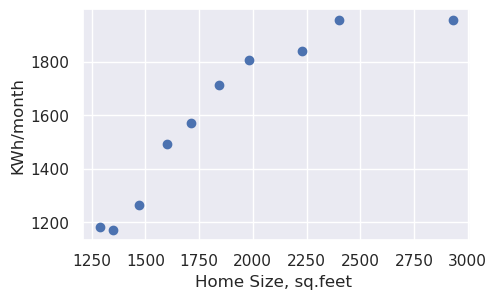

In [55]:
x = np.array([1290, 1350, 1470, 1600, 1710, 1840, 1980, 2230, 2400, 2930])  # Home Size in sq.feet 
y = np.array([1182, 1172, 1264, 1493, 1571, 1711, 1804, 1840, 1956, 1954])  # KWh/month

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # set plot styles

plt.figure(figsize=(5, 3))
plt.scatter(x,y)
plt.ylabel('KWh/month')
plt.xlabel('Home Size, sq.feet ')
plt.show()

We fit a second order (quadratic) polynomial:

In [57]:
coeffs = np.polyfit(x, y, deg=2)  # fit a polynomial of degree n=2
poly = np.poly1d(coeffs)  # the fitted polynomial
print("The fitted polynomial:")
print(poly)

The fitted polynomial:
          2
-0.00045 x + 2.399 x - 1216


Finally, we plot the fitted polynomial:

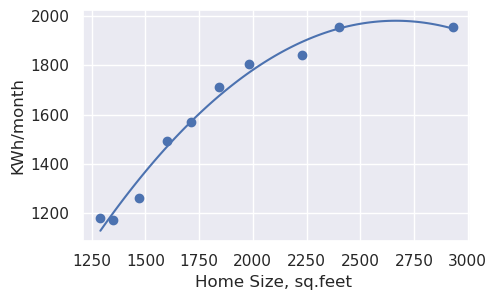

In [58]:
xp = np.linspace(x.min(), x.max(), 100)  # 100 points between x_min and x_max
yp = poly(xp)  # 100 fitted values                        

plt.figure(figsize=(5, 3))
plt.scatter(x,y)
plt.plot(xp,yp)
plt.ylabel('KWh/month')
plt.xlabel('Home Size, sq.feet ')
plt.show()

What is the predicted electricity consumption of a 4000 sq.feet house?

In [46]:
x0 = 4000
print(f"A {x0} sq.feet house is predicted to consume {poly(x0).round(2)} KWh/month.")

A 4000 sq.feet house is predicted to consume 1178.93 KWh/month.


What has gone wrong with this prediction?

## UFuncs: Learning More

More information on universal functions (including the full list of available functions) can be found on the [NumPy](http://www.numpy.org) and [SciPy](http://www.scipy.org) documentation websites.

Recall that you can also access information directly from within IPython by importing the packages and using IPython's tab-completion and help (``?``) functionality, as described in [Help and Documentation in IPython](01.01-Help-And-Documentation.ipynb).

## Exercises

**Exercise 1.3.1** Create two vectors, `v1` and `v2`, of lenght 6 with entries being random integers from 1 to 10 (including 10). Then compute:

- the elementwise sum of `v1` and `v2`
- the elementwise product of `v1` and `v2`
- the sum of all elements of `v1` (must use reduce())
- the product of all elements of `v2` (must use reduce())
- the inner product of `v1` and `v2` (must use reduce())

In [4]:
# write your solution here



**Exercise 1.3.2** Create a vector of length 13 with entries being real numbers between 0 and 2$\pi$ (including 2$\pi$). Then compute the sin (``np.sin()``) of each entry of this vector and print the result. You should round the result to three decimal places.

In [5]:
# write your solution here



**Exercise 1.3.3** Complete the following tasks and print the results:

- Create a vector of length 8 with entries set to 2

- Compute the accumulated product of this vector

- Compute the base 2 logarithm of the accumulated vector

In [6]:
# write your solution here



**Exercise 1.3.4** Find the best polynomial fit for the data in ``data/poly.csv`` and plot the fit. The first column of the data is predictor (x) and the second column is the response (y):

- Read data from the file
- Produce a scatter plot and visually inspect the data
- Fit a polynomial of a chosen degree
- Plot the fitted polynomial

In [8]:
!head -3 data/poly.csv # inspect the first three rows of the file

0.001399613, -0.23436656
0.971629779, 0.64689524
0.579119475, -0.92635765


In [7]:
# write your solution here



---

<!--NAVIGATION-->
< [1.2 – The Basics Of NumPy Arrays](L12_The_Basics_Of_NumPy_Arrays.ipynb) | [Contents](../index.ipynb) | [1.4 – Computation on arrays aggregates](L14_Computation_on_Arrays_Aggregates.ipynb) >

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; also available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*